In [1]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from io import StringIO
import numpy as np
import json
from pathlib import Path

In [2]:
def plot_version_comparison(labels, v1, v2, ylabel="Lines of code", title=None, figsize=(6, 4),
                        width=0.25, ylim=None, rotation=0, fontsize=11, pct_decimals=1,show_pct=True):

    x = np.arange(len(labels))
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)

    fig, ax = plt.subplots(figsize=figsize)

    bars1 = ax.bar(x - width/2, v1, width, label="v1.0")
    bars2 = ax.bar(x + width/2, v2, width, label="v2.0")

    if show_pct:
        pct_change = 100 * (v2 - v1) / np.where(v1 == 0, np.nan, v1)
        for bar, pct in zip(bars2, pct_change):
            if not np.isnan(pct):
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    f"{pct:+.{pct_decimals}f}%", ha="center", va="bottom", fontsize=fontsize - 1)

    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=fontsize, rotation=rotation, ha="right" if rotation else "center")
    ax.legend()

    if ylim:
        ax.set_ylim(*ylim)

    if title:
        ax.set_title(title)

    ax.set_axisbelow(True)
    ax.yaxis.grid(True, alpha=0.5)

    ax.get_yaxis().set_major_formatter(lambda x, p: f"{int(x):,}" )

    plt.tight_layout()
    # plt.show()

In [3]:
def run_cloc_all(path):
    """
    Run cloc on Gammapy and return a DataFrame with:
    - Python API
    - Python Tests
    - DocStrings
    - reStructuredText, C, and Others
    """
    # API code
    result_api = subprocess.run(
        ["cloc", "--not-match-d=test", "--json", path],
        capture_output=True, text=True, check=True
    )
    # Tests
    result_test = subprocess.run(
        ["cloc", "--match-d=test", "--json", path],
        capture_output=True, text=True, check=True
    )

    api_data = pd.read_json(StringIO(result_api.stdout)).T
    test_data = pd.read_json(StringIO(result_test.stdout)).T

    # Initialize dictionary
    stats = defaultdict(int)

    # Python API / Tests / DocStrings
    if "Python" in api_data.index:
        stats["Python API"] = api_data.loc["Python", "code"]
        stats["DocStrings"] = api_data.loc["Python", "comment"]
    if "Python" in test_data.index:
        stats["Python Tests"] = test_data.loc["Python", "code"]

    # Other languages from API cloc output
    for lang in api_data.index:
        if lang not in ["Python", "SUM"]:
            stats[lang] = api_data.loc[lang, "code"]

    # Compute Others (sum of small languages if >5)
    others = defaultdict(int)
    i = 0
    for lang, row in api_data.iterrows():
        if lang not in ["Python", "SUM", "reStructuredText", "C"]:
            if i >= 5:  # group everything after top 5
                others[lang] = row["code"]
            i += 1
    if others:
        stats["Others"] = sum(others.values())

    # Convert to DataFrame
    df = pd.DataFrame(stats, index=[0])
    return df

In [4]:
def cloc_stats(path):
    result = subprocess.run(
        ["cloc", "--json", path],
        capture_output=True,
        text=True,
        check=True,
    )

    data = pd.read_json(StringIO(result.stdout)).T
    python = data.loc["Python"]

    total = python["code"] + python["comment"]

    return {
        "code_%": 100 * python["code"] / total,
        "docs_%": 100 * python["comment"] / total,
        "blank": python["blank"],
        "code": python["code"],
        "comment": python["comment"],
    }

In [5]:
def count_lines_by_type(repo_path):
    """
    Count lines of code in code, docs, and tutorials for Gammapy.
    Returns a dictionary with 'Code', 'Docs', 'Tutorials'.
    """
    paths = {
        "Code": f"{repo_path}/gammapy",
        "Docs": f"{repo_path}/docs",
        "Tutorials": f"{repo_path}/examples"
    }
    
    stats = {}
    
    for key, path in paths.items():
        try:
            # Run cloc on the folder, get JSON output
            result = subprocess.run(
                ["cloc", "--json", path],
                capture_output=True,
                text=True,
                check=True
            )
            data = pd.read_json(StringIO(result.stdout)).T
            # Sum all code lines for all languages
            if "SUM" in data.index:
                stats[key] = data.loc["SUM", "code"]
            else:
                stats[key] = 0
        except subprocess.CalledProcessError:
            stats[key] = 0  # folder might not exist
    return stats

In [6]:
def loc_by_subpackage(repo_path):
    """
    Count lines of code per Gammapy subpackage,
    excluding scripts, tests, and extern.
    """
    base = Path(repo_path) / "gammapy"
    ignore = {"scripts", "tests", "extern"}

    stats = {}

    for subpkg in base.iterdir():
        if not subpkg.is_dir():
            continue
        if subpkg.name in ignore:
            continue

        try:
            result = subprocess.run(
                ["cloc", "--json", str(subpkg)],
                capture_output=True,
                text=True,
                check=True
            )
            data = json.loads(result.stdout)
            stats[subpkg.name] = data.get("SUM", {}).get("code", 0)
        except subprocess.CalledProcessError:
            stats[subpkg.name] = 0

    return stats

### First download the zips from: 
https://github.com/gammapy/gammapy/releases/tag/v1.0

https://github.com/gammapy/gammapy/releases/tag/v2.0

In [7]:
path_v1 = "gammapy-1.0"
path_v2 = "gammapy-2.0"

## Run the functionalities

In [8]:
df_cloc_all_v1 = run_cloc_all(path_v1)
df_cloc_all_v1

,Python API,DocStrings,Python Tests,header,reStructuredText,Text,YAML,JSON,SVG,CSS,make,DOS Batch,Markdown,INI,Cython,TOML,Others
0,34703.0,26382.0,22555.0,NaN,9576.0,1233.0,781.0,367.0,298.0,257.0,210.0,150.0,112.0,95.0,68.0,28.0,920.0


In [9]:
df_cloc_all_v2 = run_cloc_all(path_v2)
df_cloc_all_v2

,Python API,DocStrings,Python Tests,header,reStructuredText,Text,YAML,JSON,make,DOS Batch,INI,Markdown,Cython,CSS,TOML,JavaScript,HTML,Others
0,47261.0,35141.0,32600.0,NaN,11213.0,1504.0,921.0,552.0,210.0,150.0,121.0,112.0,91.0,45.0,37.0,10.0,8.0,574.0


In [10]:
cloc_stats(path_v1)

{'code_%': 67.56047385968645,
 'docs_%': 32.43952614031354,
 'blank': 21297.0,
 'code': 57144.0,
 'comment': 27438.0}

In [11]:
cloc_stats(path_v2)

{'code_%': 68.61324545478011,
 'docs_%': 31.386754545219883,
 'blank': 27969.0,
 'code': 79743.0,
 'comment': 36478.0}

## Paper 1 plot

In [12]:
labels = ["Python API", "Python Tests", "DocStrings", "reStructuredText", "Others"]
sizes_v1 = np.array([df_cloc_all_v1[label].values[0] for label in labels])
sizes_v2 = np.array([df_cloc_all_v2[label].values[0] for label in labels])

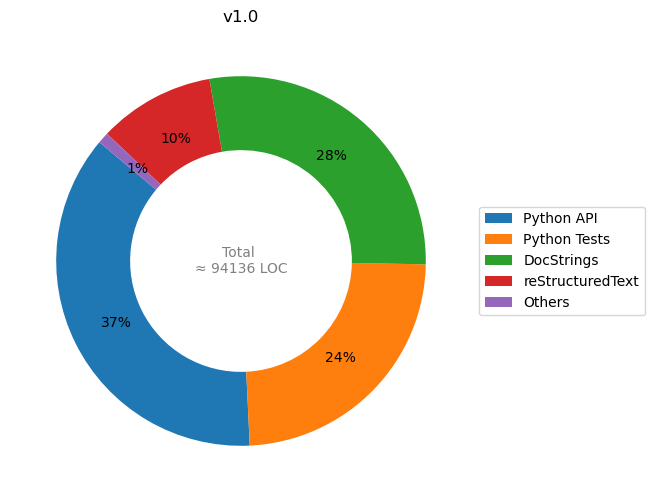

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    sizes_v1,
    labels=None,  
    autopct="%1.0f%%",
    startangle=140,
    pctdistance=0.75,
    wedgeprops=dict(width=0.4)  # makes the donut
)
centre_circle = plt.Circle((0,0), 0.4, color='white', fc='white', linewidth=0)
ax.add_artist(centre_circle)
total = sum(sizes_v1)
ax.text(0, 0, f"Total \n≈ {total:.0f} LOC", ha='center', va='center', fontsize=10, color='gray')
ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title('v1.0')
plt.show()

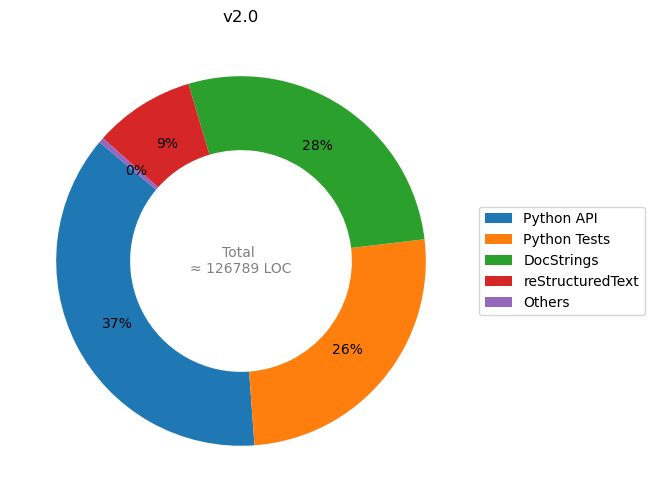

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    sizes_v2,
    labels=None,  
    autopct="%1.0f%%",
    startangle=140,
    pctdistance=0.75,
    wedgeprops=dict(width=0.4)  # makes the donut
)
centre_circle = plt.Circle((0,0), 0.4, color='white', fc='white', linewidth=0)
ax.add_artist(centre_circle)
total = sum(sizes_v2)
ax.text(0, 0, f"Total \n≈ {total:.0f} LOC", ha='center', va='center', fontsize=10, color='gray')
ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title('v2.0')
plt.savefig('LOC_v1_piechart.pdf', bbox_inches='tight')
# plt.show()

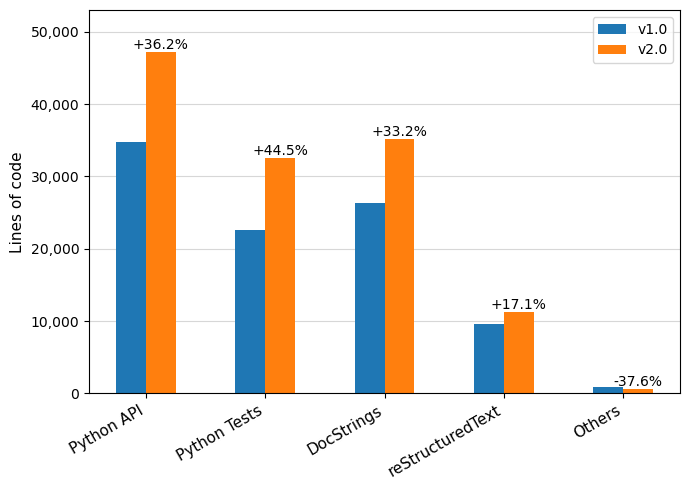

In [15]:
plot_version_comparison(labels=labels, v1=sizes_v1, v2=sizes_v2, figsize=(7, 5), width=0.25, rotation=30, ylim=(0, 53000))
plt.savefig('LOC_pie_comparison.pdf', bbox_inches='tight')

In [16]:
categories = ["Code", "Docs", "Tutorials"]

stats_v1 = count_lines_by_type(path_v1)
stats_v2 = count_lines_by_type(path_v2)

v1 = np.array([stats_v1[c] for c in categories])
v2 = np.array([stats_v2[c] for c in categories])

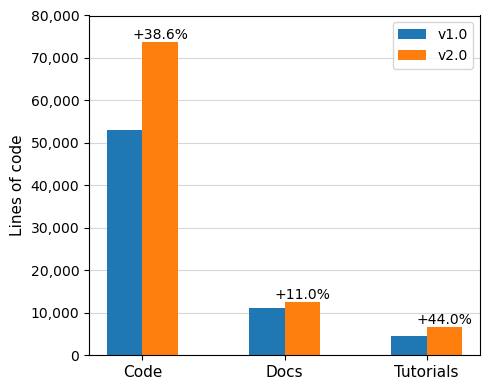

In [17]:
plot_version_comparison(labels=categories, v1=v1, v2=v2, figsize=(5, 4), width=0.25, ylim=(0, 80000))
plt.savefig('LOC_type.pdf', bbox_inches='tight')

In [18]:
# check if i include blank lines
# write summary
# include as script 

In [19]:
loc_subpackage_v1 = loc_by_subpackage(path_v1)
loc_subpackage_v2 = loc_by_subpackage(path_v2)

df = pd.DataFrame({"v1.0": loc_subpackage_v1,  "v2.0": loc_subpackage_v2}).fillna(0)
df = df.sort_values("v2.0", ascending=False)

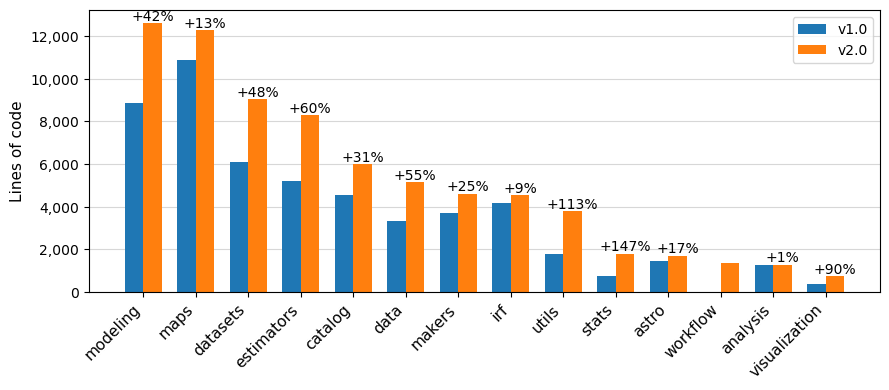

In [20]:
plot_version_comparison(labels=df.index, v1=df["v1.0"], v2=df["v2.0"], figsize=(9, 4),  width=0.35, rotation=45, pct_decimals=0)
plt.savefig('LOC_subpackages.pdf', bbox_inches='tight')

In [21]:
def count_tutorial_files(version_path):
    """
    Count the number of .py files in all tutorial folders.
    """
    tutorials_path = Path(version_path) / "examples" / "tutorials"
    if not tutorials_path.exists():
        return 0

    py_files = list(tutorials_path.rglob("*.py"))
    return len(py_files)

In [22]:
num_tutorials_v1 = count_tutorial_files(path_v1)
num_tutorials_v2 = count_tutorial_files(path_v2)

In [23]:
100 * (num_tutorials_v2 - num_tutorials_v1) / np.where(num_tutorials_v1 == 0, np.nan, num_tutorials_v1)

np.float64(41.666666666666664)

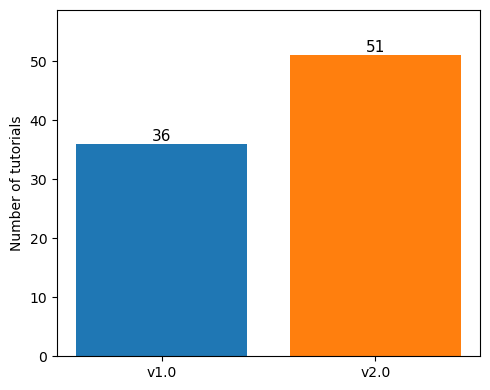

In [24]:
fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(["v1.0", "v2.0"], [num_tutorials_v1, num_tutorials_v2], color=["#1f77b4", "#ff7f0e"])
for bar, count in zip(bars, [num_tutorials_v1, num_tutorials_v2]):
    ax.text(bar.get_x() + bar.get_width() / 2,bar.get_height(),str(count),
        ha="center",va="bottom",fontsize=11)
ax.set_ylabel("Number of tutorials")
ax.set_ylim(0, max([num_tutorials_v1, num_tutorials_v2]) * 1.15)
plt.tight_layout()
plt.show()

In [25]:
# According to zenodo authors
# https://zenodo.org/records/7311399
num_contributors_v1 = 44

# https://zenodo.org/records/17814297
num_contributors_v2 = 51

In [26]:
100 * (num_contributors_v2 - num_contributors_v1) / np.where(num_contributors_v1 == 0, np.nan, num_contributors_v1)

np.float64(15.909090909090908)

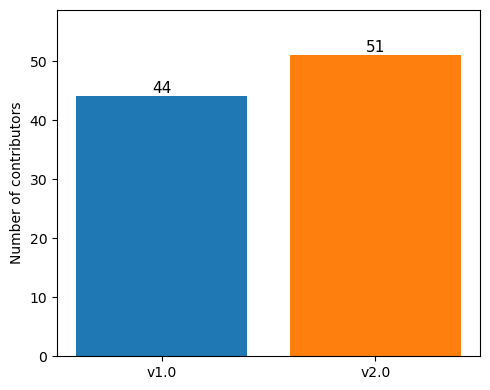

In [27]:
fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(["v1.0", "v2.0"], [num_contributors_v1, num_contributors_v2], color=["#1f77b4", "#ff7f0e"])
for bar, count in zip(bars, [num_contributors_v1, num_contributors_v2]):
    ax.text(bar.get_x() + bar.get_width() / 2,bar.get_height(),str(count),
        ha="center",va="bottom",fontsize=11)
ax.set_ylabel("Number of contributors")
ax.set_ylim(0, max([num_contributors_v1, num_contributors_v2]) * 1.15)
plt.tight_layout()
plt.show()

In [28]:
# compare zenodo stats

/tmp/ipykernel_119533/2203565304.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("commits_by_date.txt", delim_whitespace=True, names=["count", "date"])


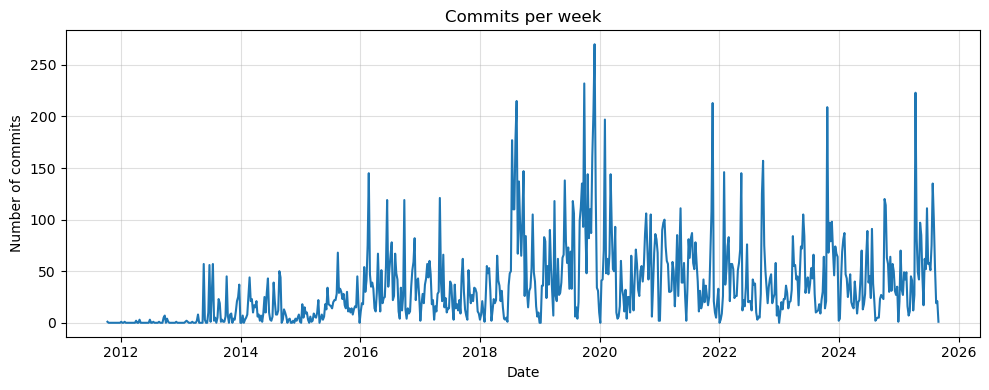

In [29]:
df = pd.read_csv("commits_by_date.txt", delim_whitespace=True, names=["count", "date"])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

weekly = df['count'].resample('W').sum()

plt.figure(figsize=(10,4))
plt.plot(weekly.index, weekly.values, color="#1f77b4")
plt.title("Commits per week")
plt.ylabel("Number of commits")
plt.xlabel("Date")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

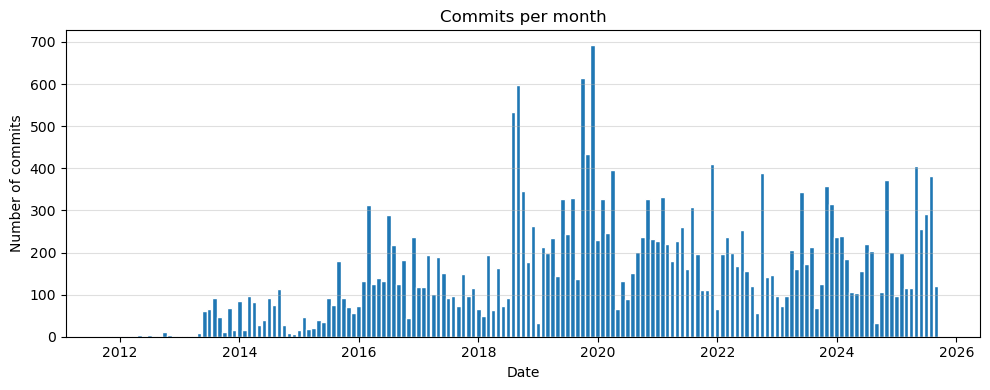

In [30]:
monthly = df['count'].resample('ME').sum()

# Plot monthly commits
plt.figure(figsize=(10,4))
plt.bar(monthly.index, monthly.values, width=28, color="#1f77b4", edgecolor="white")
plt.title("Commits per month")
plt.xlabel("Date")
plt.ylabel("Number of commits")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()